In [10]:
import os
import sys
import folium
import json
import pandas as pd
import geopandas as gpd
import plotly.express as px
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from googletrans import Translator
from typing import List
from datetime import datetime
from PIL import Image


sys.path.append("../../src/heat_waves")
sys.path.append("../../src")
import analyse_heatwaves as hw
import plots as hw_plots
import maps as hw_maps
import load_locations as lloader

# Get Meteostat Data

In [11]:
stations, _ = hw.get_stations_from_location(location="Prague", max_distance=20000)


# stations_hw = hw_functions.compute_heat_stats_stations(stations, start=2013, end=2024) 
# station_comparison_location = hw_functions.compare_parameter_stations(stations) #displayed as a carpet plot in col2
stations


station_id    station_name country region  latitude  longitude  elevation  \
0      11520     Praha-Libus      CZ     PR   50.0167    14.4500      304.0   
1      11567     Praha Kbely      CZ     PR   50.1167    14.5333      286.0   
2      11518  Praha / Ruzyne      CZ     ST   50.1000    14.2500      365.0   
3      LKVO0       Vodochody      CZ     ST   50.2166    14.3958      280.0   

       distance location  
0   4780.157933   Prague  
1   8868.855834   Prague  
2  14719.757712   Prague  
3  17823.899290   Prague

<Axes: >

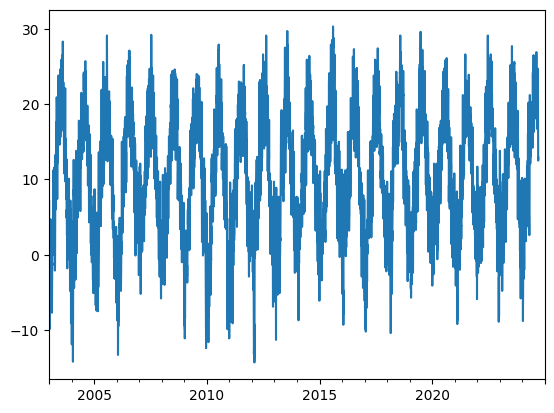

In [12]:
hw.get_daily_station(stations.loc[0,"station_id"], start_year=2003, end_year=2024).tavg.plot()

# Get Golemio Sensor Data

In [13]:
GOLEMIO_KEY = os.environ.get("GOLEMIO_KEY")
districts = lloader.get_golemio('v2/citydistricts', GOLEMIO_KEY)
districts_df = pd.DataFrame.from_dict(districts)
districts_gdf = gpd.GeoDataFrame.from_features(districts_df.iloc[:,0], crs="EPSG:4326")
districts_gdf.head()

geometry  id            name  \
0  POLYGON ((14.31810 49.98889, 14.31799 49.98921...   1  Praha-Řeporyje   
1  POLYGON ((14.32370 50.07615, 14.32244 50.07621...   3         Praha 6   
2  POLYGON ((14.47849 50.09771, 14.47925 50.09813...   4         Praha 9   
3  POLYGON ((14.45301 50.00255, 14.45307 50.00246...  10        Praha 12   
4  POLYGON ((14.55423 50.01216, 14.55419 50.01220...  38  Praha-Křeslice   

             slug updated_at  
0  praha-reporyje       None  
1         praha-6       None  
2         praha-9       None  
3        praha-12       None  
4  praha-kreslice       None

In [14]:
locations = lloader.get_golemio('v2/microclimate/locations', GOLEMIO_KEY)
locations_df = pd.DataFrame.from_dict(locations)
print(locations_df.shape)
locations_df.head()

(19, 7)


location_id                        location  \
0          110    Vnitroblok Kodaňská-Estonská   
1          120  Vnitroblok Orlická-Vinohradská   
2          130     Pražská Holešovická tržnice   
3          140               Náměstí Republiky   
4          150                  Heroldovy sady   

                        loc_description         loc_orientation   loc_surface  \
0                  vnitroblok se zelení      není specifikováno         zeleň   
1                 vnitroblok bez zeleně      není specifikováno        dlažba   
2                      areál bez zeleně            východ-západ  asfalt/beton   
3  veřejné pěší prostranství bez zeleně               sever-jih        dlažba   
4                veřejný park se zelení  všechny světové strany   zeleň/mlato   

                                 address  \
0           Vnitroblok Kodaňská-Estonská   
1  Vnitroblok Orlická-Vinohradská fasáda   
2                        Pražská tržnice   
3                      Náměstí Republiky   
4                         Heroldovy sady   

                                              points  
0  [{'point_id': 111, 'point_name': 'Vnitroblok K...  
1  [{'point_id': 121, 'point_name': 'Vnitroblok O...  
2  [{'point_id': 131, 'point_name': 'Pražská tržn...  
3  [{'point_id': 141, 'point_name': 'Náměstí Repu...  
4  [{'point_id': 151, 'point_name': 'Heroldovy sa...

In [15]:
points = lloader.get_golemio('v2/microclimate/points', GOLEMIO_KEY)
points_df = pd.DataFrame.from_dict(points)
print(points_df.shape)
points_df.head()

(38, 15)


point_id  location_id                              point_name  \
0       111          110  Vnitroblok Kodaňská-Estonská osvětlení   
1       112          110      Vnitroblok Kodaňská-Estonská strom   
2       121          120   Vnitroblok Orlická-Vinohradská fasáda   
3       131          130               Pražská tržnice osvětlení   
4       132          130             Pražská tržnice jižní strom   

                         location        loc_description     loc_orientation  \
0    Vnitroblok Kodaňská-Estonská   vnitroblok se zelení  není specifikováno   
1    Vnitroblok Kodaňská-Estonská   vnitroblok se zelení  není specifikováno   
2  Vnitroblok Orlická-Vinohradská  vnitroblok bez zeleně  není specifikováno   
3     Pražská Holešovická tržnice       areál bez zeleně        východ-západ   
4     Pražská Holešovická tržnice       areál bez zeleně        východ-západ   

    loc_surface        lat        lng x_jtsk y_jtsk elevation_m  \
0         zeleň  50.070933  14.452466   None   None        None   
1         zeleň  50.070944  14.452619   None   None        None   
2        dlažba  50.077782  14.455145   None   None        None   
3  asfalt/beton  50.098934  14.445022   None   None        None   
4  asfalt/beton  50.098815  14.445016   None   None        None   

                                            measures    sensor_position  \
0  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...          osvětlení   
1  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...              strom   
2  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...                zeď   
3  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...  veřejné osvětlení   
4  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...              strom   

                sensor_position_detail  
0                  osvětlení v pergole  
1                                strom  
2                                  zeď  
3  veřejné osvětlení ve středu Tržnice  
4                          jižní strom

In [16]:
def translate_df(df:pd.DataFrame, translate_cols:List[str]) -> pd.DataFrame:
    """ based on https://towardsdatascience.com/translate-a-pandas-data-frame-using-googletrans-library-fb0aa7fca592
    """
    df_en = df.copy()

    # create a translator object
    translator = Translator()

    # Translate all unique items
    translations = {}
    for column in translate_cols:
        unique_elements = df_en[column].unique()
        for element in unique_elements:
            translations[element] = translator.translate(element).text
        df_en.rename(columns=lambda x: translator.translate(x).text, inplace=True)
    
    df_en.replace(translations, inplace=True)
    return df_en, translations

paths = ["../../data/interim/prague_sensors/locations_cz.csv", 
          "../../data/interim/prague_sensors/locations_en.csv", 
         "../../data/interim/prague_sensors/points_cz.csv", 
         "../../data/interim/prague_sensors/points_en.csv"]

if all([os.path.exists(p) for p in paths]):
    locations_df = pd.read_csv("../../data/interim/prague_sensors/locations_cz.csv")
    locations_df_en = pd.read_csv("../../data/interim/prague_sensors/locations_en.csv")
    points_df = pd.read_csv("../../data/interim/prague_sensors/points_cz.csv")
    points_df_en = pd.read_csv("../../data/interim/prague_sensors/points_en.csv")

else:
    DO_TRANSLATION = True

    if DO_TRANSLATION:
        locations_df_en, translations = translate_df(locations_df, ['loc_description', 'loc_orientation', 'loc_surface'])
        print(locations_df_en.shape)
        locations_df_en.head()

        points_df_en = points_df.copy()
        points_df_en.replace(translations, inplace=True)

        translate_cols = ['sensor_position', 'sensor_position_detail',]
        points_df_en, translations = translate_df(points_df_en, translate_cols)
        points_df_en.head()
        points_df
    else:
        points_df_en = points_df

    locations_df.to_csv("../../data/interim/prague_sensors/locations_cz.csv")
    locations_df_en.to_csv("../../data/interim/prague_sensors/locations_en.csv")
    points_df.to_csv("../../data/interim/prague_sensors/points_cz.csv")
    points_df_en.to_csv("../../data/interim/prague_sensors/points_en.csv")

In [17]:
points_df_en.head()

Unnamed: 0  point_id  location_id                              point_name  \
0           0       111          110  Vnitroblok Kodaňská-Estonská osvětlení   
1           1       112          110      Vnitroblok Kodaňská-Estonská strom   
2           2       121          120   Vnitroblok Orlická-Vinohradská fasáda   
3           3       131          130               Pražská tržnice osvětlení   
4           4       132          130             Pražská tržnice jižní strom   

                         location               loc_description  \
0    Vnitroblok Kodaňská-Estonská     inner block with greenery   
1    Vnitroblok Kodaňská-Estonská     inner block with greenery   
2  Vnitroblok Orlická-Vinohradská  inner block without greenery   
3     Pražská Holešovická tržnice         area without greenery   
4     Pražská Holešovická tržnice         area without greenery   

  loc_orientation       loc_surface        lat        lng  x_jtsk  y_jtsk  \
0   not specified          greenery  50.070933  14.452466     NaN     NaN   
1   not specified          greenery  50.070944  14.452619     NaN     NaN   
2   not specified          pavement  50.077782  14.455145     NaN     NaN   
3       east-west  asphalt/concrete  50.098934  14.445022     NaN     NaN   
4       east-west  asphalt/concrete  50.098815  14.445016     NaN     NaN   

   elevation_m                                           measures  \
0          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
1          NaN  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...   
2          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
3          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
4          NaN  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...   

   sensor_position                             sensor_position_detail  
0         lighting                            lighting in the pergola  
1            strom                                              strom  
2             wall                                               wall  
3  public lighting  public lighting in the center of the Market Sq...  
4            strom                                      southern tree

In [14]:
points_gdf_en = gpd.GeoDataFrame(points_df_en, 
                       geometry=gpd.points_from_xy(points_df.lng, points_df.lat), 
                       crs="EPSG:4326")
points_gdf_en.head()

Unnamed: 0  point_id  location_id                              point_name  \
0           0       111          110  Vnitroblok Kodaňská-Estonská osvětlení   
1           1       112          110      Vnitroblok Kodaňská-Estonská strom   
2           2       121          120   Vnitroblok Orlická-Vinohradská fasáda   
3           3       131          130               Pražská tržnice osvětlení   
4           4       132          130             Pražská tržnice jižní strom   

                         location               loc_description  \
0    Vnitroblok Kodaňská-Estonská     inner block with greenery   
1    Vnitroblok Kodaňská-Estonská     inner block with greenery   
2  Vnitroblok Orlická-Vinohradská  inner block without greenery   
3     Pražská Holešovická tržnice         area without greenery   
4     Pražská Holešovická tržnice         area without greenery   

  loc_orientation       loc_surface        lat        lng  x_jtsk  y_jtsk  \
0   not specified          greenery  50.070933  14.452466     NaN     NaN   
1   not specified          greenery  50.070944  14.452619     NaN     NaN   
2   not specified          pavement  50.077782  14.455145     NaN     NaN   
3       east-west  asphalt/concrete  50.098934  14.445022     NaN     NaN   
4       east-west  asphalt/concrete  50.098815  14.445016     NaN     NaN   

   elevation_m                                           measures  \
0          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
1          NaN  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...   
2          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
3          NaN  [{'measure': 'air_hum200', 'measure_cz': 'Vlhk...   
4          NaN  [{'measure': 'air_hum50', 'measure_cz': 'Vlhko...   

   sensor_position                             sensor_position_detail  \
0         lighting                            lighting in the pergola   
1            strom                                              strom   
2             wall                                               wall   
3  public lighting  public lighting in the center of the Market Sq...   
4            strom                                      southern tree   

                    geometry  
0  POINT (14.45247 50.07093)  
1  POINT (14.45262 50.07094)  
2  POINT (14.45514 50.07778)  
3  POINT (14.44502 50.09893)  
4  POINT (14.44502 50.09881)

In [20]:
lst_split = gpd.read_feather("../../data/processed/Prague_districts_lst.feather")
lst_split.sample()

geometry  id              name  \
38  POLYGON ((14.53902 50.08096, 14.53912 50.08097...  46  Praha-Štěrboholy   

                slug updated_at  band    lst_min  lst_mean    lst_max  \
38  praha-sterboholy       None     1  32.140137  39.59201  51.430161   

    pixel_count  total_area  district_id  -20 <= lst < 27  27 <= lst < 32  \
38         2674    0.000371           46              0.0             0.0   

    32 <= lst < 40  40 <= lst < 100  
38        0.599102         0.400898

In [15]:
hw_maps.plot_dots_on_districts(districts_gdf, points_gdf_en, "point_id")

Get all data for one sensor

In [16]:
measures = ['air_hum200', 'air_hum50', 'air_temp200', 'air_temp50',
       'precip300', 'pressure200', 'pressure50', 'sun_irr200',
       'wind_dir300', 'wind_impact300', 'wind_speed300', 'soil_temp-10', 'soil_temp-30', 'water_pot-10',
       'water_pot-30']

df_hourly, df_daily, metadata = lloader.get_id_hourly_daily(id=151, 
                                                            measures=measures, 
                                                            start_date="2024-06-01T00:00:00", 
                                                            save_path="../../data/interim/prague_sensors")
metadata

/v2/microclimate/measurements?pointId=151&measure=air_hum200&from=2024-06-01T00:00:00


/v2/microclimate/measurements?pointId=151&measure=air_hum50&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=air_temp200&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=air_temp50&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=precip300&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=pressure200&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=pressure50&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=sun_irr200&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=wind_dir300&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=wind_impact300&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=wind_speed300&from=2024-06-01T00:00:00
/v2/microclimate/measurements?pointId=151&measure=soil_temp-10&from=2024-06-01T00:00:00
soil_temp-10 has length 0
/v2/microclimate/m

point_id location_id         measure  unit
2024-08-27 12:13:00+00:00      151         150      air_hum200     %
1                              151         150       air_hum50     %
2                              151         150     air_temp200    °C
3                              151         150      air_temp50    °C
4                              151         150       precip300    mm
5                              151         150     pressure200    Pa
6                              151         150      pressure50    Pa
7                              151         150      sun_irr200   lux
8                              151         150     wind_dir300     °
9                              151         150  wind_impact300  km/h
10                             151         150   wind_speed300  km/h

In [39]:
temperature_path = "../../data/interim/prague_sensors/air_temp200_2024-06-01-2024-08-23_daily.csv"

if os.path.exists(temperature_path):
    df_hourly = pd.read_csv("../../data/interim/prague_sensors/air_temp200_2024-06-01-2024-08-23_hourly.csv", index_col="measured_at")
    df_hourly.index = pd.to_datetime(df_hourly.index)
    df_daily = pd.read_csv("../../data/interim/prague_sensors/air_temp200_2024-06-01-2024-08-23_daily.csv", index_col="measured_at")
    df_daily.index = pd.to_datetime(df_daily.index)
else:
    df_hourly, df_daily, metadata = lloader.get_measure(ids=list(points_gdf_en.point_id.values), 
                                                measure="air_temp200", 
                                                start_date="2024-06-01T00:00:00", 
                                                save_path="../../data/interim/prague_sensors")
    df_hourly.head()



In [40]:
time = "2024-08-18 13:00:00+00:00"
points_this_hour = df_hourly.dropna().T.loc[:, time].rename("air_temp200")
points_this_hour.index = points_this_hour.index.astype(int) # ensure index is int before merge
points_this_hour = points_gdf_en.merge(points_this_hour, left_on="point_id", right_index=True)
hw_maps.plot_dots_on_districts(districts_gdf, points_this_hour, "air_temp200")

In [41]:
fig = px.line(df_hourly, 
              color_discrete_sequence=px.colors.qualitative.Plotly,
              title="Hourly Mean Temperature ")
fig.update_layout(
    legend_title="Sensor"
)
fig.show()

In [42]:
px.line(df_daily.loc[:, [c for c in df_daily.columns if c.endswith("mean")]], 
              color_discrete_sequence=px.colors.qualitative.Plotly, 
              title="Daily mean tempearture (°C)")

In [43]:
hw_plots.plot_hourly_carpet(df=df_hourly, unit="°C", title="Point 171 <br> air_temp200", col="171")

In [44]:
df_sub = df_hourly.loc["2024-08-10 00:00:00+00:00":"2024-08-18 00:00:00+00:00", :]
mean = df_sub.mean(axis=1)
df_sub = df_sub.assign(mean=mean)
df_delta = df_sub.drop(columns="mean").subtract(mean, axis=0)
df_delta.head()

111       121       131       141       151  \
measured_at                                                                   
2024-08-10 00:00:00+00:00  0.528571  0.628571  1.028571  1.128571  0.028571   
2024-08-10 01:00:00+00:00  0.576190  1.176190  0.576190  1.576190 -0.723810   
2024-08-10 02:00:00+00:00  0.715000  1.015000  0.515000  1.515000 -0.985000   
2024-08-10 03:00:00+00:00  0.680952  0.580952  0.880952  0.880952  0.180952   
2024-08-10 04:00:00+00:00  0.450000  0.450000  0.750000  0.850000  0.050000   

                                153       161       162       171       172  \
measured_at                                                                   
2024-08-10 00:00:00+00:00 -0.371429  0.928571  1.028571  0.928571  0.828571   
2024-08-10 01:00:00+00:00 -0.623810  1.176190  1.376190  1.176190  1.076190   
2024-08-10 02:00:00+00:00 -0.685000  1.015000  1.215000  0.915000  0.815000   
2024-08-10 03:00:00+00:00 -0.119048  0.980952  0.980952  0.780952  0.780952   
2024-08-10 04:00:00+00:00 -0.150000  0.750000  0.850000  0.650000  0.850000   

                           ...       191       201       211       221  \
measured_at                ...                                           
2024-08-10 00:00:00+00:00  ... -0.171429  0.928571 -3.171429 -0.171429   
2024-08-10 01:00:00+00:00  ...  0.776190  1.276190 -2.923810 -0.123810   
2024-08-10 02:00:00+00:00  ...  0.815000  1.115000 -2.085000 -0.285000   
2024-08-10 03:00:00+00:00  ...  0.680952  0.880952 -1.619048 -0.419048   
2024-08-10 04:00:00+00:00  ...  0.550000  0.850000 -1.250000 -0.450000   

                                231       233       241       251       262  \
measured_at                                                                   
2024-08-10 00:00:00+00:00 -0.071429  0.028571  0.428571  0.328571 -1.171429   
2024-08-10 01:00:00+00:00 -0.323810 -0.023810 -0.323810  0.576190 -2.223810   
2024-08-10 02:00:00+00:00       NaN -0.585000 -0.085000  0.015000 -1.185000   
2024-08-10 03:00:00+00:00 -1.119048 -1.019048 -0.019048  0.080952 -0.419048   
2024-08-10 04:00:00+00:00       NaN -1.050000 -0.250000 -0.550000 -0.350000   

                                271  
measured_at                          
2024-08-10 00:00:00+00:00 -0.671429  
2024-08-10 01:00:00+00:00 -1.423810  
2024-08-10 02:00:00+00:00 -1.285000  
2024-08-10 03:00:00+00:00 -1.519048  
2024-08-10 04:00:00+00:00 -1.150000  

[5 rows x 21 columns]

In [45]:
fig = px.line(df_delta, 
              y=df_delta.columns, 
              color_discrete_sequence=px.colors.qualitative.Plotly,
              title="T_mean - T_sensor"
              )
              
fig.update_layout(
    legend_title="Sensor"
)
fig.show()

In [74]:
df_delta["hour"] = df_delta.index.hour
hourly_mean = df_delta.groupby("hour").agg("mean")
#hourly_mean.rename(columns={c: f'{points_gdf_en.loc[points_gdf_en.point_id==int(c), "loc_description"].values[0].replace(" ", "_")}_{c}' for c in hourly_mean.columns}, inplace=True)

In [77]:
points_gdf_en.loc_description.unique()

array(['inner block with greenery', 'inner block without greenery',
       'area without greenery', 'public pedestrian area without greenery',
       'public park with greenery', 'streets with greenery',
       'streets without greenery', 'square with greenery',
       'a traffic hub without greenery', 'dopravní uzel se zelení',
       'street with private greenery', 'open space with greenery',
       'agricultural area with greenery', 'space with greenery',
       'terrace with artificial grass'], dtype=object)

In [76]:
{c: f'{points_gdf_en.loc[points_gdf_en.point_id==int(c), "loc_description"].values[0].replace(" ", "_")}' for c in hourly_mean.columns}

{'111': 'inner_block_with_greenery',
 '121': 'inner_block_without_greenery',
 '131': 'area_without_greenery',
 '141': 'public_pedestrian_area_without_greenery',
 '151': 'public_park_with_greenery',
 '153': 'public_park_with_greenery',
 '161': 'streets_with_greenery',
 '162': 'streets_with_greenery',
 '171': 'streets_without_greenery',
 '172': 'streets_without_greenery',
 '181': 'public_park_with_greenery',
 '191': 'square_with_greenery',
 '201': 'streets_without_greenery',
 '211': 'a_traffic_hub_without_greenery',
 '221': 'street_with_private_greenery',
 '231': 'open_space_with_greenery',
 '233': 'open_space_with_greenery',
 '241': 'public_park_with_greenery',
 '251': 'streets_with_greenery',
 '262': 'agricultural_area_with_greenery',
 '271': 'space_with_greenery'}

In [71]:
px.line(hourly_mean,
        color_discrete_sequence=px.colors.qualitative.Plotly,
        title="Average hourly temperature per sensor")

In [27]:
hw_plots.plot_hourly_carpet(df=df_delta, 
            unit="°C", 
            title="Point 171 <br> t_avg - air_temp200", 
            col="172",
            diff=True
            )

## Population